In [16]:
## Importing packages

# This R environment comes with all of CRAN and many other helpful packages preinstalled.
# You can see which packages are installed by checking out the kaggle/rstats docker image: 
# https://github.com/kaggle/docker-rstats

library(tidyverse) # metapackage with lots of helpful functions

## Running code

# In a notebook, you can run a single code cell by clicking in the cell and then hitting 
# the blue arrow to the left, or by clicking in the cell and pressing Shift+Enter. In a script, 
# you can run code by highlighting the code you want to run and then clicking the blue arrow
# at the bottom of this window.

## Reading in files

# You can access files from datasets you've added to this kernel in the "../input/" directory.
# You can see the files added to this kernel by running the code below. 

list.files(path = "../input")

## Saving data

# If you save any files or images, these will be put in the "output" directory. You 
# can see the output directory by committing and running your kernel (using the 
# Commit & Run button) and then checking out the compiled version of your kernel.

[1] "data.csv"

**#Objective: Predict Customer Life-time Value for an Auto Insurance Company
For an Auto Insurance company, predict the customer life time value (CLV). CLV is the total revenue the client will
derive from their entire relationship with a customer. Because we don't know how long each customer relationship will
be, we make a good estimate and state CLV as a periodic value — that is, we usually say “this customer's 12-month
(or 24-month, etc) CLV is $x”.**

In [17]:
#Importing tidyverse and reading the data from source
library("tidyverse")
#data=read_csv("../input/ibm-watson-marketing-customer-value-data/WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv")
data<-read_csv("../input/data.csv")
class(data)

Parsed with column specification:
cols(
  .default = col_character(),
  `Customer Lifetime Value` = col_double(),
  Income = col_double(),
  `Monthly Premium Auto` = col_double(),
  `Months Since Last Claim` = col_double(),
  `Months Since Policy Inception` = col_double(),
  `Number of Open Complaints` = col_double(),
  `Number of Policies` = col_double(),
  `Total Claim Amount` = col_double()
)

See spec(...) for full column specifications.



[1] "spec_tbl_df" "tbl_df"      "tbl"         "data.frame"

In [18]:
#Importing relevant packages
library(caret)
library(ggplot2)
library(dplyr)
library(Hmisc)
library(broom)
library(glmnet)
#Here we are checking dimension and structure of the data
dim(data)
glimpse(data)

[1] 9134   24

Observations: 9,134
Variables: 24
$ Customer                        <chr> "BU79786", "QZ44356", "AI49188", "WW6…
$ State                           <chr> "Washington", "Arizona", "Nevada", "C…
$ `Customer Lifetime Value`       <dbl> 2763.519, 6979.536, 12887.432, 7645.8…
$ Response                        <chr> "No", "No", "No", "No", "No", "Yes", …
$ Coverage                        <chr> "Basic", "Extended", "Premium", "Basi…
$ Education                       <chr> "Bachelor", "Bachelor", "Bachelor", "…
$ `Effective To Date`             <chr> "2/24/11", "1/31/11", "2/19/11", "1/2…
$ EmploymentStatus                <chr> "Employed", "Unemployed", "Employed",…
$ Gender                          <chr> "F", "F", "F", "M", "M", "F", "F", "M…
$ Income                          <dbl> 56274, 0, 48767, 0, 43836, 62902, 553…
$ `Location Code`                 <chr> "Suburban", "Suburban", "Suburban", "…
$ `Marital Status`                <chr> "Married", "Single", "Married", "Marr…
$ `Monthly Premium

In [19]:
#levels(data$State)
#Summary of the data
summary(data)
#chaeck for missing values
sum(is.na(data))
#getting column names and renaming those
names(data)
names(data)<-c("Customer","State","CLV","Response","Coverage","Education","Effective.To.Date","EmploymentStatus","Gender","Income","Location.Code","Marital.Status","Monthly.Premium.Auto","Months.Since.Last.Claim","Month.Since.Policy.Inception","Open.Complaints","Policies","Policy.Type","Policy","Renew.Offer.Type","Sales.Channel","Total.Claim.Amount","Vehicle.Class","Vehicle.Size")
#colnames(data)

   Customer            State           Customer Lifetime Value
 Length:9134        Length:9134        Min.   : 1898          
 Class :character   Class :character   1st Qu.: 3994          
 Mode  :character   Mode  :character   Median : 5780          
                                       Mean   : 8005          
                                       3rd Qu.: 8962          
                                       Max.   :83325          
   Response           Coverage          Education         Effective To Date 
 Length:9134        Length:9134        Length:9134        Length:9134       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
 EmploymentStatus   

[1] 0

[1] "Customer"                      "State"                        
 [3] "Customer Lifetime Value"       "Response"                     
 [5] "Coverage"                      "Education"                    
 [7] "Effective To Date"             "EmploymentStatus"             
 [9] "Gender"                        "Income"                       
[11] "Location Code"                 "Marital Status"               
[13] "Monthly Premium Auto"          "Months Since Last Claim"      
[15] "Months Since Policy Inception" "Number of Open Complaints"    
[17] "Number of Policies"            "Policy Type"                  
[19] "Policy"                        "Renew Offer Type"             
[21] "Sales Channel"                 "Total Claim Amount"           
[23] "Vehicle Class"                 "Vehicle Size"

[1] 9134   22

                                    Income Monthly.Premium.Auto
Income                        1.0000000000         -0.016664550
Monthly.Premium.Auto         -0.0166645503          1.000000000
Months.Since.Last.Claim      -0.0267151791          0.005026285
Month.Since.Policy.Inception -0.0008751978          0.020256643
Open.Complaints               0.0064082726         -0.013121673
Policies                     -0.0086562031         -0.011233031
Total.Claim.Amount           -0.3552543174          0.632016663
                             Months.Since.Last.Claim
Income                                  -0.026715179
Monthly.Premium.Auto                     0.005026285
Months.Since.Last.Claim                  1.000000000
Month.Since.Policy.Inception            -0.042959206
Open.Complaints                          0.005354132
Policies                                 0.009136079
Total.Claim.Amount                       0.007562974
                             Month.Since.Policy.Inception Open.C

NULL

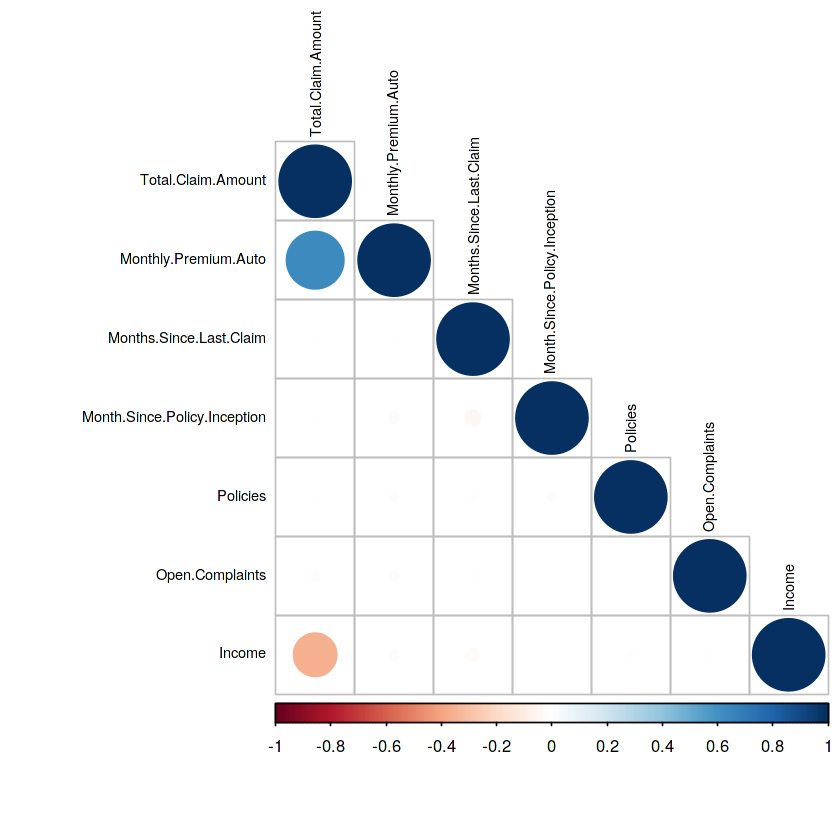

In [20]:
#Discarding insignificant features first(intuitive sense) 
data<-data[,-c(1,7)]
dim(data)
#subsetting with numerical variables
new_data<-subset(data,select=-c(CLV))
new_data<-new_data[sapply(new_data,is.numeric)]
#scale it
#new_data<-scale(new_data, center=TRUE, scale=TRUE)
#find correlation matrix
corr<-cor(new_data)
print(corr)
highlyCorrelated<-findCorrelation(corr, cutoff=0.5)
print(highlyCorrelated)
names<-colnames(highlyCorrelated)
names
library(corrplot)
corrplot(corr, order="FPC", method="circle", type="lower", tl.cex=0.7, tl.col=rgb(0,0,0))

In [ ]:
#I found a high correlation between Monthly.Premium.Auto,Total.Claim.Amount and Total.Claim.Amount,Income variables
#My task is to remove one of those highly correlated variables. I removed Total.Claim.Amount
#We could use Ordered Least Square method or PCA or Ridge regression

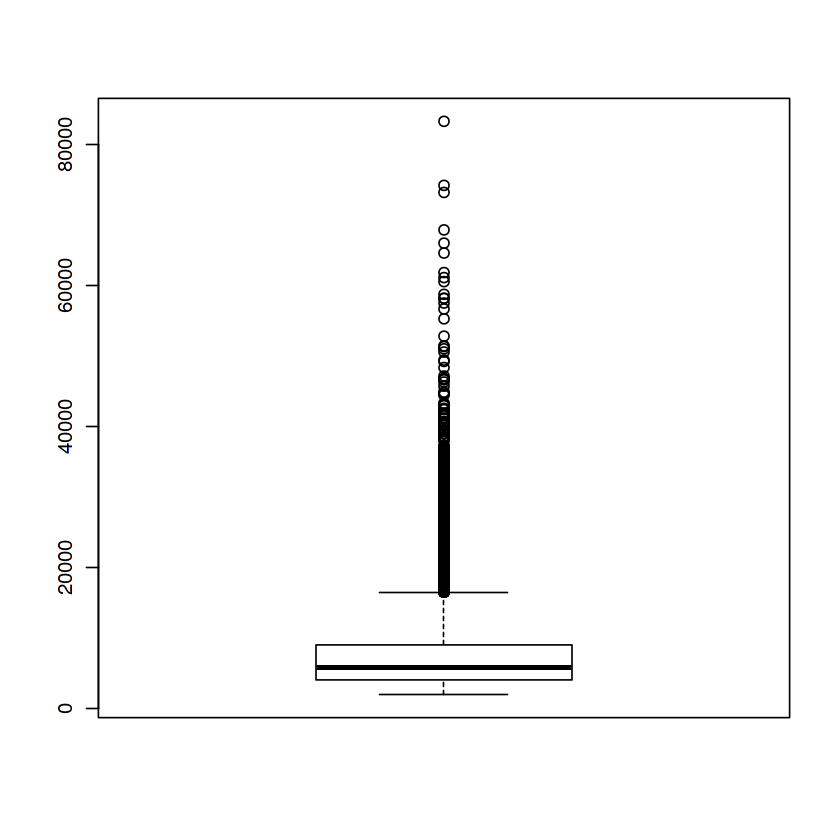

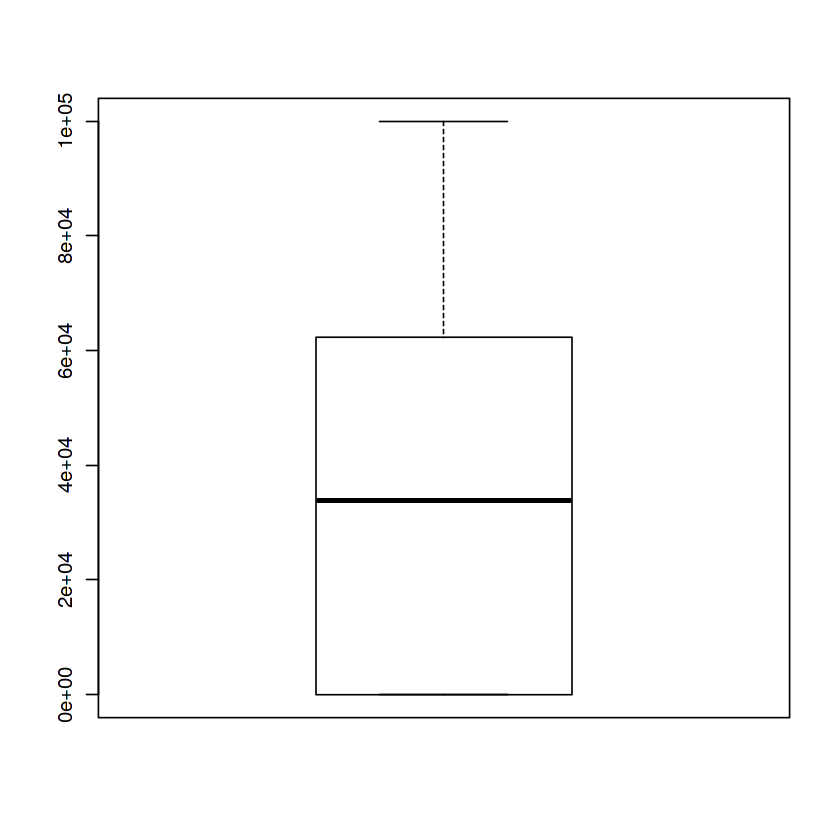

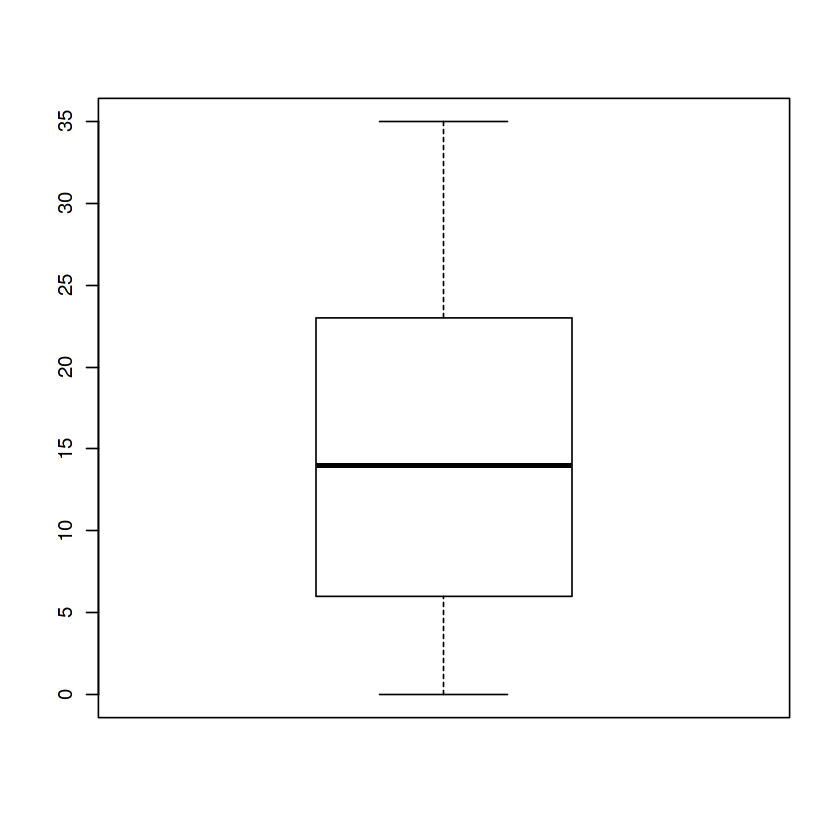

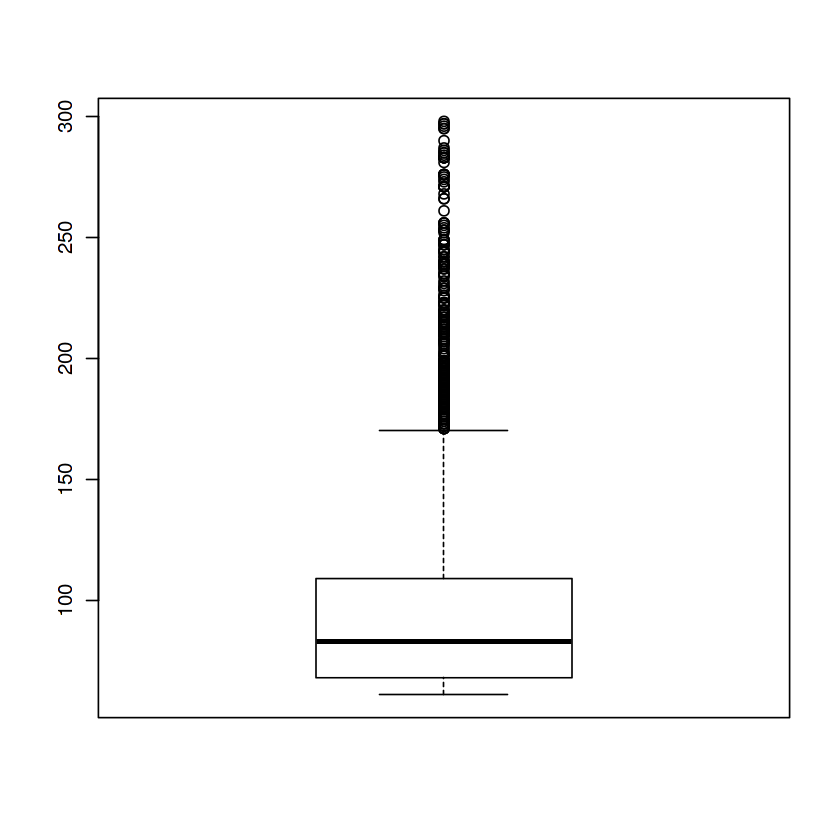

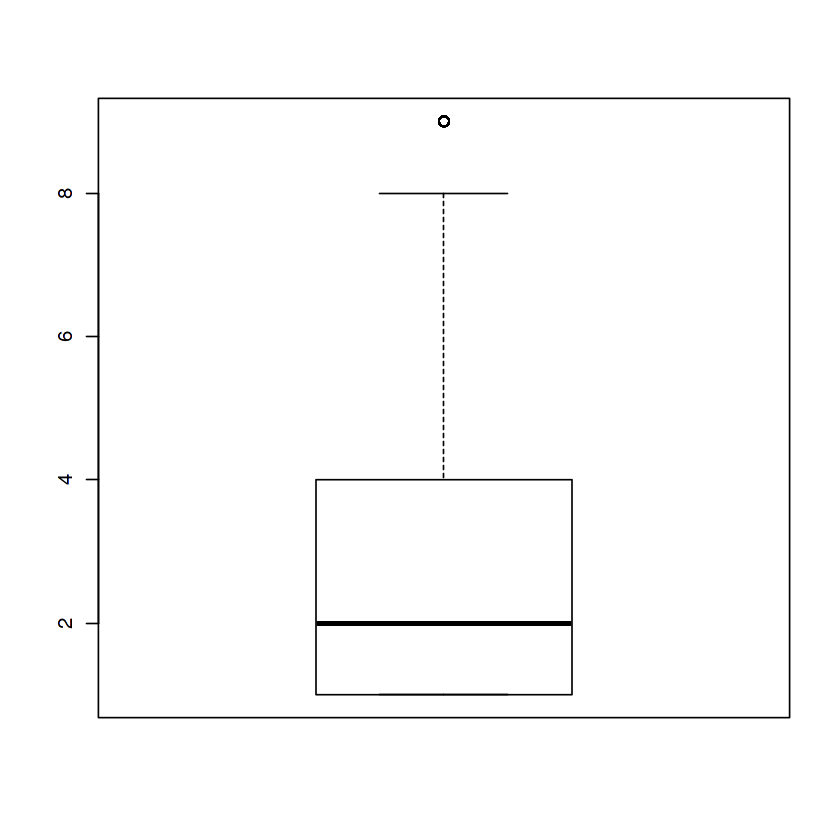

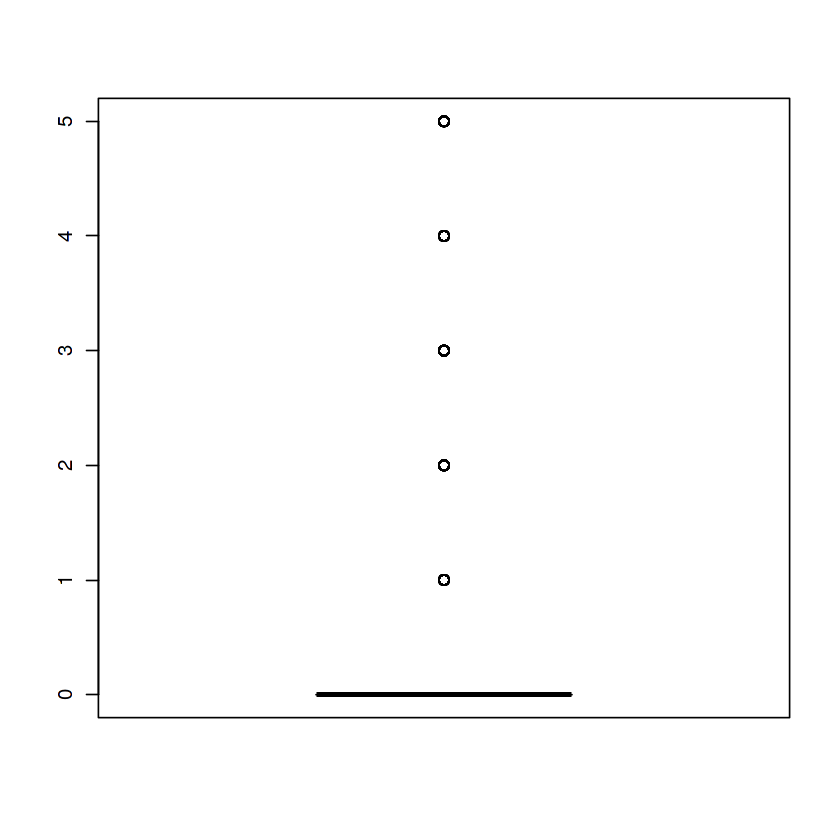

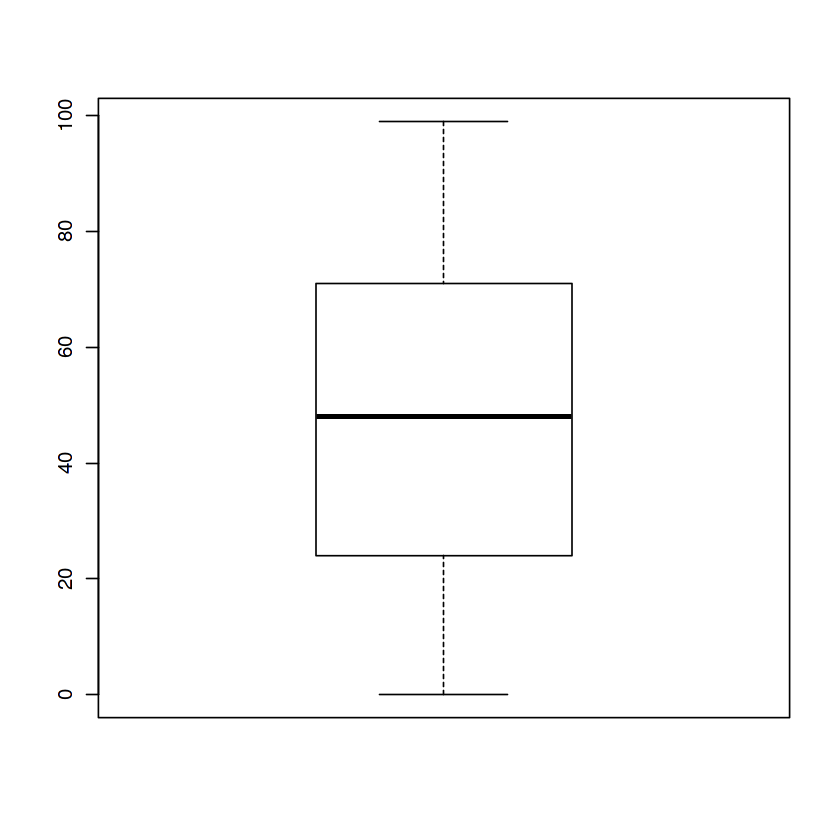

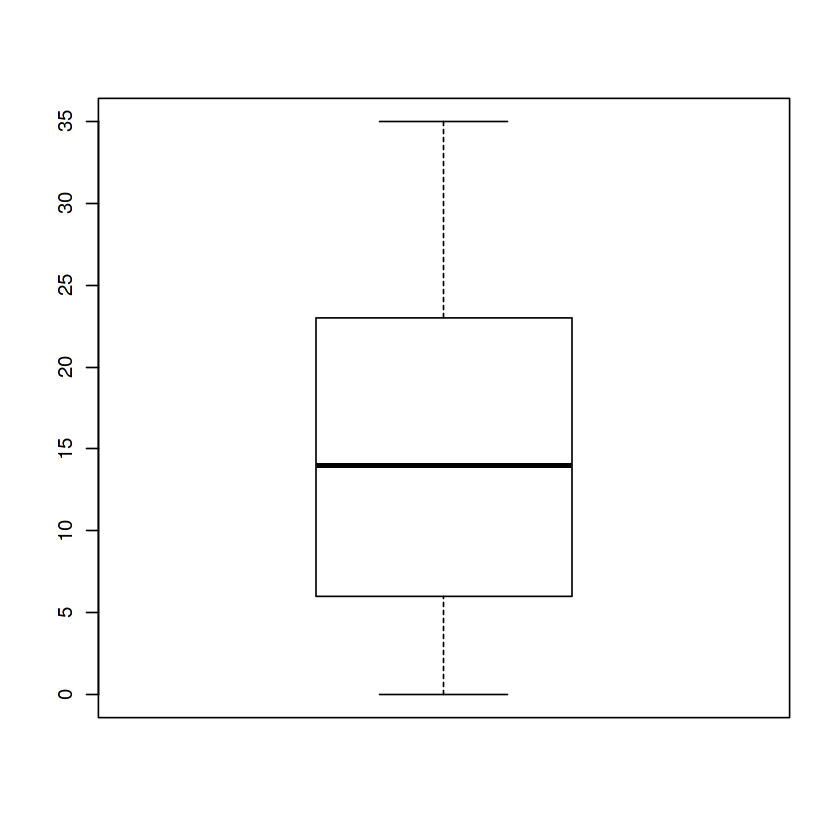

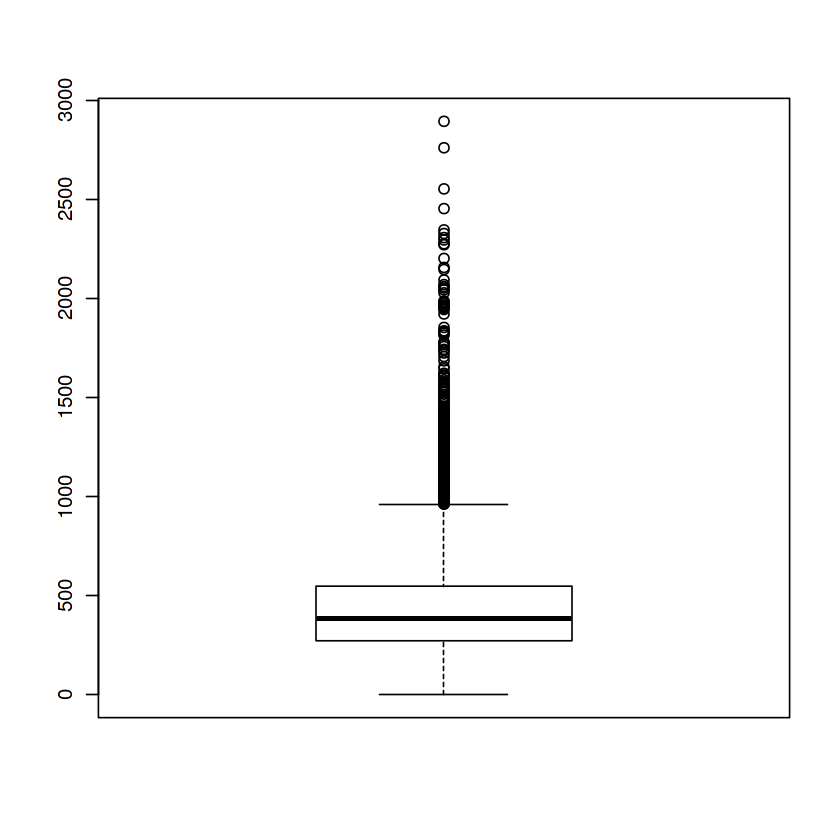

In [21]:
#length(new_d$Total.Claim.Amount)
#dim(data)
#dim(new_data)
#names(new_data)
#Discarding insignificant features(intution)
#data<-data[,-c(1,7)]
data1<-data
#Checking for outliers
boxplot(data1$CLV)#treatment require
boxplot(data1$Income)
boxplot(data1$Months.Since.Last.Claim)
boxplot(data1$Monthly.Premium.Auto)#treatment require
boxplot(data1$Policies)
boxplot(data1$Open.Complaints)
boxplot(data1$Month.Since.Policy.Inception)
boxplot(data1$Months.Since.Last.Claim)
boxplot(data1$Total.Claim.Amount)#treatment require

In [ ]:
boxplot(data1$Total.Claim.Amount)
summary(data1$Total.Claim.Amount)
upper<-272.258+1.5*(547.515-272.258)
data1<-subset(data1,data1$Total.Claim.Amount<=upper)
boxplot(data1$Total.Claim.Amount)

In [ ]:
boxplot(data1$Monthly.Premium.Auto)
summary(data1$Monthly.Premium.Auto)
u_range<-67.00+1.5*(102.00-67.00)
data1<-subset(data1,data1$Monthly.Premium.Auto<=u_range)
boxplot(data1$Monthly.Premium.Auto)

In [ ]:
boxplot(data1$CLV)
summary(data1$CLV)
range<-3543+1.5*(8288-3543)
data1<-subset(data1,data1$CLV<=range)
boxplot(data1$CLV)

In [22]:
set.seed(999)
#Doing variable transformation(from character to factor)
data1$State<-as.factor(data1$State)
data1$Sales.Channel<-as.factor(data1$Sales.Channel)
data1$Response<-as.factor(data1$Response)
data1$Coverage<-as.factor(data1$Coverage)
data1$Education<-as.factor(data1$Education)
data1$EmploymentStatus<-as.factor(data1$EmploymentStatus)
data1$Gender<-as.factor(data1$Gender)
data1$Location.Code<-as.factor(data1$Location.Code)
data1$Marital.Status<-as.factor(data1$Marital.Status)
data1$Policy.Type<-as.factor(data1$Policy.Type)
data1$Policy<-as.factor(data1$Policy)
data1$Renew.Offer.Type<-as.factor(data1$Renew.Offer.Type)
data1$Vehicle.Class<-as.factor(data1$Vehicle.Class)
data1$Vehicle.Size<-as.factor(data1$Vehicle.Size)

In [24]:
#scale the numerical features, merge the data to fit into lm()
data2<-scale(data1[,c(2,8,11:15,20)],center=TRUE, scale=TRUE)
data1<-cbind(data2,data1[,-c(2,8,11:15,2)])
data1<-data1[, !duplicated(colnames(data1))]
dmy<-dummyVars(CLV~.,data1,fullRank=TRUE)
new<-data.frame(predict(dmy,data1))
#dim(data1)
#colnames(data1)
str(new)
new$CLV<-data1$CLV

'data.frame':	9134 obs. of  50 variables:
 $ Income                        : num  0.613 -1.24 0.366 -1.24 0.203 ...
 $ Monthly.Premium.Auto          : num  -0.7039 0.0227 0.4296 0.3714 -0.5876 ...
 $ Months.Since.Last.Claim       : num  1.678 -0.208 0.288 0.288 -0.307 ...
 $ Month.Since.Policy.Inception  : num  -1.543 -0.217 -0.361 0.607 -0.146 ...
 $ Open.Complaints               : num  -0.422 -0.422 -0.422 -0.422 -0.422 ...
 $ Policies                      : num  -0.823 2.106 -0.404 1.688 -0.823 ...
 $ Total.Claim.Amount            : num  -0.17 2.401 0.456 0.33 -1.019 ...
 $ State.California              : num  0 0 0 1 0 0 0 0 0 0 ...
 $ State.Nevada                  : num  0 0 1 0 0 0 0 0 0 0 ...
 $ State.Oregon                  : num  0 0 0 0 0 1 1 0 1 1 ...
 $ State.Washington              : num  1 0 0 0 1 0 0 0 0 0 ...
 $ Response.Yes                  : num  0 0 0 0 0 1 1 0 1 0 ...
 $ Coverage.Extended             : num  0 1 0 0 0 0 0 0 0 1 ...
 $ Coverage.Premium              : 

In [ ]:
#glimpse(data1)
#If we use caret then we would follow the following steps
dmy<-dummyVars(CLV~.,data1,fullRank=TRUE)
new<-data.frame(predict(dmy,data1))
dim(new)
head(new,10)
new$CLV<-data1$CLV

In [ ]:
set.seed(50000)
index<-createDataPartition(new$CLV, p=0.80, list=FALSE)
train<-new[index,]
test<-new[-index,]
#model<-train(CLV~., train, method="lm", preProcess=c("center"))
#print(model)
#summary(model)

In [ ]:
set.seed(50000)
control<-trainControl(method="cv", number=10)
model<-train(CLV~., train, method="lm", metric="RMSE", trControl=control, preProcess=c("center","scale","BoxCox"))
summary(model)
#imp<-varImp(model, scale=FALSE)
#plot(imp)

In [ ]:
model2<-train(1/CLV~., train, method="lm", metric="Rsquared", trControl=control, preProcess=c("center","scale","BoxCox"))
summary(model2)


In [ ]:
imp<-varImp(model, scale=FALSE)
plot(imp)

In [ ]:
#model3<-lm(CLV~Policies+Monthly.Premium.Auto+EmploymentStatus.Medical.Leave+Open.Complaints+EmploymentStatus.Unemployed+Income+Policy.Corporate.L2+Coverage.Extended+Policy.Type.Personal.Auto,train)
#summary(model3)
final_model<-train(1/CLV~Policies+Monthly.Premium.Auto+EmploymentStatus.Medical.Leave+Open.Complaints+EmploymentStatus.Unemployed+Income+Policy.Corporate.L2+Coverage.Extended+Policy.Type.Personal.Auto,train,method="lm",metric="Rsquared",trControl=control,preProcess=c("center","scale","BoxCox"))
summary(final_model)

In [ ]:
final_model<-lm(CLV~Policies+Monthly.Premium.Auto+EmploymentStatus.Medical.Leave+Open.Complaints+EmploymentStatus.Unemployed+Income+Policy.Corporate.L2+Coverage.Extended+Policy.Type.Personal.Auto,new)
#Diagnostic Check
#Linearity of the relationship between explanatory varibales and its target variable: residual vs fitted
#Error terms are normally distributed: Q-Q plot
plot(final_model)
#No correlation between variables: Autocorrelation Durbin-Watson
durbin.watson(final_model)
#Multicollinearity
corr<-cor(new_data)
print(corr)
highlyCorrelated<-findCorrelation(corr, cutoff=0.5)
print(highlyCorrelated)
names<-colnames(highlyCorrelated)
names
library(corrplot)
corrplot(corr, order="FPC", method="circle", type="lower", tl.cex=0.7, tl.col=rgb(0,0,0))
#alternative way
library(car)
vif(final_model)

In [ ]:
#Prediction
pred<-predict(model,test)
pred
#table(pred,test[,c('CLV')])
#summary of the  model
#looking at adjusted R-squared and AIC-BIC
summary(model)
summary(model)$coeff
summary(model)$r.squared
summary(model)$adj.r.suared#'ll be more focus on that
#AIC(model)
#BIC(model)
#Model Diagnostic and Scoring
residuals<-resid(model)
predValues<-predict(model,newData)
plot(newData$CLV,residuals)
abline(0,0)
plot(newData$CLV,predValues)

pred<-predict(model,newData)
actual_pred<-data.frame(cbind(newData$CLV,pred))
cor(actual_pred)
head(actual_pred)

In [ ]:
#We could use glmnet as well
library(dplyr)
y<-train$CLV
x<-train[,-42]%>%data.matrix()
lamb<-seq(1,0,-0.001)
#grid<-expand.grid(alpha=0,lambda=lamb)
#fit.glmnet<-train(train,train$CLV,method='glmnet',metric='Rsquared',maximize=FALSE,trControl=control,tuneGrid=grid)
fit.glmnet<-glmnet(x,y,alpha=0,lambda=lamb)
summary(fit.glmnet)

In [ ]:
#saveRDS(model,"https://drive.google.com/drive/my-drive/final_model.rds")